In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [150]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import tiktoken
from tqdm import tqdm
import numpy as np

In [125]:
CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 80, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 6,          # Number of attention heads
    "n_layers": 6,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [14]:
EOT_TOKEN_ID = 50256 

In [3]:
import torch
import torch.nn as nn

In [145]:

class SelfAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(0.01) # New
        

    def forward(self, x, attention_mask=None):
        b, num_tokens, d_in = x.shape
        keys    = self.W_key(x)
        queries = self.W_query(x)
        values  = self.W_value(x)
    
        # Compute raw attention scores
        attn_scores = queries @ keys.transpose(1, 2)
    
        # Apply mask if provided
        if attention_mask is not None:
            # attention_mask shape: (B, seq_len)
            # expand to (B, 1, seq_len) to broadcast over query positions
            mask = attention_mask[:, None, :]
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))
    
        # Softmax + dropout
        attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)
    
        # Weighted sum
        context_vec = attn_weights @ values
        return context_vec

        
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [SelfAttention(d_in, d_out, context_length, qkv_bias) 
             for _ in range(num_heads)]
        )

    def forward(self, x,mask):
        return torch.cat([head(x,mask) for head in self.heads], dim=-1)


In [146]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [152]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttentionWrapper(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = nn.LayerNorm(cfg["emb_dim"])
        self.norm2 = nn.LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x,mask):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x,mask)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

In [154]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = nn.LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], 2, bias=True
        )

    def forward(self, in_idx,mask):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x,mask)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


In [105]:
import pandas
dataset=pd.read_csv("/kaggle/input/sentiment-analysis-dataset/train.csv",encoding="latin1")

In [106]:
dataset.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [107]:
dataset.dropna(inplace=True)

In [108]:
dataset.isnull().sum()

textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [109]:
dataset["text"] = dataset["text"].astype(str)


In [110]:
dataset["text"] = dataset["text"].str.replace(r"\s+", " ", regex=True).str.strip()


In [111]:
LABEL_MAP = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

dataset["label"] = dataset["sentiment"].map(LABEL_MAP)
dataset = dataset.dropna(subset=["label"])

In [112]:
dataset=dataset[["text","label"]]

In [113]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")


In [47]:
import matplotlib.pyplot as plt


In [114]:
sentiment_counts = dataset["label"].value_counts()

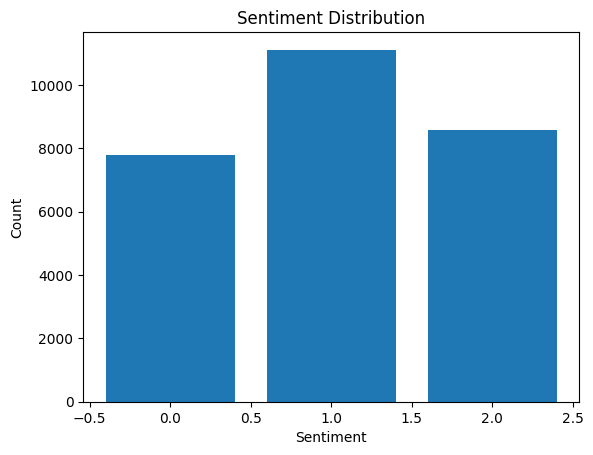

In [115]:
plt.figure()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.show()


In [116]:
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)


In [99]:
import sklearn
from sklearn.model_selection import train_test_split


In [129]:
df_train,df_test=train_test_split(dataset,test_size=0.2)

In [130]:
df_train

,text,label
22903,has a tummy ache.,0
14565,_M Thanks for remembering,2
12541,Happy Star Wars Day! .... May the 4th Be with ...,2
16647,"#liesboystell Your the only one, I love (they ...",0
2020,aww sorry to hear you are having a bad time. R...,0
...,...,...
8221,People are just pisssing me offf. Ugh,0
24564,oops. Cy`s place is too near. Trouble for me.,0
23790,"In rural #thailand, 2630 is considered posh",1
293,"Har Har, #swineflu is everywhere: http://twitp...",1


In [119]:
leno= dataset["text"].apply(
    lambda x: len(tokenizer.encode(x))
)


<Axes: ylabel='Frequency'>

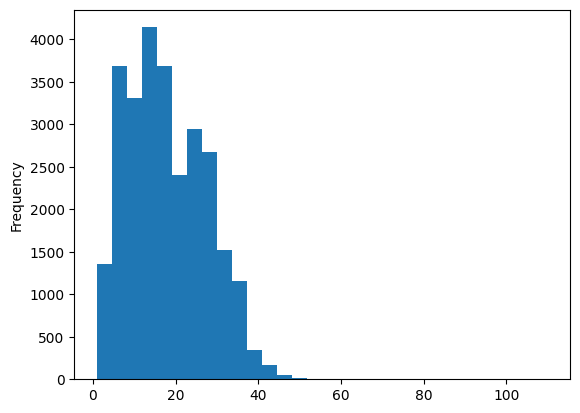

In [120]:
leno.plot(kind="hist",bins=30)

In [121]:
leno.describe(percentiles=[0.9, 0.95, 0.99])

count    27480.000000
mean        18.007387
std          9.566531
min          1.000000
50%         17.000000
90%         31.000000
95%         35.000000
99%         40.000000
max        110.000000
Name: text, dtype: float64

In [163]:
import torch
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.texts = dataframe["text"].fillna("").astype(str).tolist()
        self.labels = dataframe["label"].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]  # ✅ use iloc, not loc or df[idx]
        text = str(row["text"])
        tokens=self.tokenizer.encode(text)
        labels = int(row["sentiment"])

        return {
            "input_ids": torch.tensor(tokens, dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }


In [164]:
MAX_LEN = CONFIG["context_length"]

def collate_fn(batch):
    input_ids = [item["input_ids"][:MAX_LEN] for item in batch]
    labels = torch.stack([item["labels"] for item in batch])

    input_ids = pad_sequence(
        input_ids,
        batch_first=True,
        padding_value=tokenizer.eot_token
    )

    attention_mask = (input_ids != tokenizer.eot_token).long()

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }


In [173]:

import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.texts = dataframe["text"].fillna("").astype(str).tolist()
        self.labels = dataframe["label"].tolist()
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # Use the pre-processed lists instead of accessing dataframe
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize the text
        tokens = self.tokenizer.encode(text)
        
        return {
            "input_ids": torch.tensor(tokens, dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# Collate function
def collate_fn(batch, tokenizer, max_len):
    input_ids = [item["input_ids"][:max_len] for item in batch]
    labels = torch.stack([item["labels"] for item in batch])
    
    input_ids = pad_sequence(
        input_ids,
        batch_first=True,
        padding_value=tokenizer.eot_token
    )
    
    attention_mask = (input_ids != tokenizer.eot_token).long()
    
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [176]:
from torch.utils.data import DataLoader

train_dataset = SentimentDataset(df_train, tokenizer)
val_dataset   = SentimentDataset(df_test, tokenizer)

train_loader = DataLoader(
    df_train,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    df_test,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)


In [139]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc="Training")
    for batch in pbar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        optimizer.zero_grad()
        
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for batch in pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            
            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


# ==================== PREDICTION ====================

def predict(model, text, tokenizer, device, max_len=80):
    """Predict sentiment for a single text"""
    model.eval()
    
    # Tokenize
    tokens = tokenizer.encode(text)[:max_len]
    input_ids = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    attention_mask = torch.ones_like(input_ids).to(device)
    
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(logits, dim=1).item()
    
    label_map = {0: "negative", 1: "neutral", 2: "positive"}
    
    return {
        "predicted_class": predicted_class,
        "predicted_label": label_map[predicted_class],
        "probabilities": {
            "negative": probabilities[0][0].item(),
            "neutral": probabilities[0][1].item(),
            "positive": probabilities[0][2].item()
        }
    }


def predict_batch(model, dataloader, device):
    """Predict sentiment for a batch of texts"""
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            logits = model(input_ids, attention_mask)
            _, predicted = torch.max(logits, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)


In [155]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
tokenizer = tiktoken.get_encoding("gpt2")
model = GPTModel( CONFIG).to(device)
    
    # Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
    
    # Training loop
num_epochs = 3
best_val_acc = 0

Using device: cuda


In [177]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved best model with accuracy: {best_val_acc:.2f}%")

# Example prediction
sample_text = "I love this product! It's amazing!"
result = predict(model, sample_text, tokenizer, device)
print(f"\nSample prediction: {result}")


Epoch 1/3
--------------------------------------------------


Training:   0%|          | 0/687 [00:00<?, ?it/s]


KeyError: 12424

In [179]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import tiktoken
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# ==================== Configuration ====================
CONFIG = {
    "vocab_size": 50257,
    "context_length": 80,
    "emb_dim": 768,
    "n_heads": 6,
    "n_layers": 6,
    "drop_rate": 0.1,
    "qkv_bias": False
}

EOT_TOKEN_ID = 50256

# ==================== Model Components ====================
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))


class SelfAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(0.01)

    def forward(self, x, attention_mask=None):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.transpose(1, 2)
        
        if attention_mask is not None:
            mask = attention_mask[:, None, :]
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))
        
        attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context_vec = attn_weights @ values
        return context_vec


class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList([
            SelfAttention(d_in, d_out, context_length, qkv_bias) 
            for _ in range(num_heads)
        ])

    def forward(self, x, mask):
        return torch.cat([head(x, mask) for head in self.heads], dim=-1)


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttentionWrapper(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"] // cfg["n_heads"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = nn.LayerNorm(cfg["emb_dim"])
        self.norm2 = nn.LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x, mask):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x, mask)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.ModuleList([
            TransformerBlock(cfg) for _ in range(cfg["n_layers"])
        ])
        
        self.final_norm = nn.LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], 3, bias=True)  # 3 classes

    def forward(self, in_idx, mask):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        
        for block in self.trf_blocks:
            x = block(x, mask)
        
        x = self.final_norm(x)
        # Pool: take mean of all tokens (excluding padding)
        mask_expanded = mask.unsqueeze(-1).float()
        x = (x * mask_expanded).sum(dim=1) / mask_expanded.sum(dim=1)
        logits = self.out_head(x)
        return logits


# ==================== Dataset ====================
class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.texts = dataframe["text"].fillna("").astype(str).tolist()
        self.labels = dataframe["label"].tolist()
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = self.tokenizer.encode(text)
        
        return {
            "input_ids": torch.tensor(tokens, dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long),
        }


def collate_fn(batch, max_len=80):
    input_ids = [item["input_ids"][:max_len] for item in batch]
    labels = torch.stack([item["labels"] for item in batch])
    
    input_ids = pad_sequence(
        input_ids,
        batch_first=True,
        padding_value=EOT_TOKEN_ID
    )
    
    attention_mask = (input_ids != EOT_TOKEN_ID).long()
    
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }


# ==================== Training Functions ====================
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc="Training")
    for batch in pbar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        optimizer.zero_grad()
        
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for batch in pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            
            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


# ==================== Main Training Script ====================
if __name__ == "__main__":
    # Load dataset
    dataset = pd.read_csv("/kaggle/input/sentiment-analysis-dataset/train.csv", encoding="latin1")
    
    # Preprocessing
    dataset.dropna(inplace=True)
    dataset["text"] = dataset["text"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
    
    LABEL_MAP = {"negative": 0, "neutral": 1, "positive": 2}
    dataset["label"] = dataset["sentiment"].map(LABEL_MAP)
    dataset = dataset.dropna(subset=["label"])
    dataset = dataset[["text", "label"]]
    
    # Shuffle
    dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Split
    df_train, df_test = train_test_split(dataset, test_size=0.2, random_state=42)
    
    # Tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")
    
    # Create datasets
    train_dataset = SentimentDataset(df_train, tokenizer)
    val_dataset = SentimentDataset(df_test, tokenizer)
    
    # Create dataloaders with lambda to pass max_len
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=lambda batch: collate_fn(batch, max_len=CONFIG["context_length"]),
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=lambda batch: collate_fn(batch, max_len=CONFIG["context_length"]),
        num_workers=0,
        pin_memory=True
    )
    
    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = GPTModel(CONFIG).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
    
    # Training loop
    num_epochs = 3
    best_val_acc = 0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Saved best model with accuracy: {best_val_acc:.2f}%")
    
    print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")

Using device: cuda

Epoch 1/3
--------------------------------------------------


Training: 100%|██████████| 687/687 [00:56<00:00, 12.17it/s, loss=0.9067, acc=50.43%]


Train Loss: 0.9852, Train Acc: 50.43%


Validation: 100%|██████████| 172/172 [00:04<00:00, 41.49it/s, loss=0.8967, acc=56.39%]


Val Loss: 0.9020, Val Acc: 56.39%
Saved best model with accuracy: 56.39%

Epoch 2/3
--------------------------------------------------


Training: 100%|██████████| 687/687 [00:56<00:00, 12.20it/s, loss=0.8816, acc=59.56%]


Train Loss: 0.8528, Train Acc: 59.56%


Validation: 100%|██████████| 172/172 [00:04<00:00, 41.26it/s, loss=0.8255, acc=60.77%]


Val Loss: 0.8420, Val Acc: 60.77%
Saved best model with accuracy: 60.77%

Epoch 3/3
--------------------------------------------------


Training: 100%|██████████| 687/687 [00:56<00:00, 12.17it/s, loss=0.8404, acc=65.93%]


Train Loss: 0.7577, Train Acc: 65.93%


Validation: 100%|██████████| 172/172 [00:04<00:00, 41.30it/s, loss=0.7958, acc=62.79%]


Val Loss: 0.8224, Val Acc: 62.79%
Saved best model with accuracy: 62.79%

Training completed! Best validation accuracy: 62.79%


In [180]:
def predict(model, text, tokenizer, device, max_len=80):
    """
    Predict sentiment for a single text string.
    
    Args:
        model: Trained GPTModel
        text: Input text string
        tokenizer: Tiktoken tokenizer
        device: torch device
        max_len: Maximum sequence length
    
    Returns:
        Dictionary with predicted class, label, and probabilities
    """
    model.eval()
    
    # Tokenize
    tokens = tokenizer.encode(text)[:max_len]
    input_ids = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    attention_mask = torch.ones_like(input_ids).to(device)
    
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(logits, dim=1).item()
    
    label_map = {0: "negative", 1: "neutral", 2: "positive"}
    
    return {
        "text": text,
        "predicted_class": predicted_class,
        "predicted_label": label_map[predicted_class],
        "probabilities": {
            "negative": f"{probabilities[0][0].item():.4f}",
            "neutral": f"{probabilities[0][1].item():.4f}",
            "positive": f"{probabilities[0][2].item():.4f}"
        }
    }


def predict_batch(model, texts, tokenizer, device, max_len=80, batch_size=32):
    """
    Predict sentiment for multiple texts efficiently.
    
    Args:
        model: Trained GPTModel
        texts: List of text strings
        tokenizer: Tiktoken tokenizer
        device: torch device
        max_len: Maximum sequence length
        batch_size: Batch size for prediction
    
    Returns:
        List of prediction dictionaries
    """
    model.eval()
    all_predictions = []
    label_map = {0: "negative", 1: "neutral", 2: "positive"}
    
    # Process in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        
        # Tokenize batch
        batch_tokens = [tokenizer.encode(text)[:max_len] for text in batch_texts]
        batch_ids = [torch.tensor(tokens, dtype=torch.long) for tokens in batch_tokens]
        
        # Pad sequences
        input_ids = pad_sequence(batch_ids, batch_first=True, padding_value=EOT_TOKEN_ID).to(device)
        attention_mask = (input_ids != EOT_TOKEN_ID).long().to(device)
        
        with torch.no_grad():
            logits = model(input_ids, attention_mask)
            probabilities = torch.softmax(logits, dim=1)
            predicted_classes = torch.argmax(logits, dim=1)
        
        # Format results
        for j, text in enumerate(batch_texts):
            all_predictions.append({
                "text": text,
                "predicted_class": predicted_classes[j].item(),
                "predicted_label": label_map[predicted_classes[j].item()],
                "probabilities": {
                    "negative": f"{probabilities[j][0].item():.4f}",
                    "neutral": f"{probabilities[j][1].item():.4f}",
                    "positive": f"{probabilities[j][2].item():.4f}"
                }
            })
    
    return all_predictions


def evaluate_with_metrics(model, dataloader, device):
    """
    Evaluate model and return detailed metrics including confusion matrix.
    
    Args:
        model: Trained GPTModel
        dataloader: DataLoader with test data
        device: torch device
    
    Returns:
        Dictionary with accuracy, predictions, and true labels
    """
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            logits = model(input_ids, attention_mask)
            _, predicted = torch.max(logits, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    accuracy = (all_predictions == all_labels).sum() / len(all_labels)
    
    return {
        "accuracy": accuracy,
        "predictions": all_predictions,
        "true_labels": all_labels,
        "num_samples": len(all_labels)
    }


# ==================== Example Usage ====================

# After training, load the best model:
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

# Single prediction
result = predict(model, "I love this product! It's amazing!", tokenizer, device)
print(result)

# Batch prediction
texts = [
    "This is terrible, I hate it!",
    "It's okay, nothing special.",
    "Absolutely fantastic! Best purchase ever!"
]
results = predict_batch(model, texts, tokenizer, device)
for r in results:
    print(f"{r['text'][:50]}... -> {r['predicted_label']} ({r['probabilities']})")

# Full evaluation
metrics = evaluate_with_metrics(model, val_loader, device)
print(f"Test Accuracy: {metrics['accuracy']:.4f}")


{'text': "I love this product! It's amazing!", 'predicted_class': 2, 'predicted_label': 'positive', 'probabilities': {'negative': '0.0005', 'neutral': '0.0034', 'positive': '0.9961'}}
This is terrible, I hate it!... -> negative ({'negative': '0.9559', 'neutral': '0.0321', 'positive': '0.0120'})
It's okay, nothing special.... -> neutral ({'negative': '0.1398', 'neutral': '0.7618', 'positive': '0.0984'})
Absolutely fantastic! Best purchase ever!... -> positive ({'negative': '0.0127', 'neutral': '0.0359', 'positive': '0.9514'})


Evaluating: 100%|██████████| 172/172 [00:03<00:00, 43.09it/s]

Test Accuracy: 0.6279
